In [ ]:

import pandas as pd
import numpy as np
import nbimporter
import feature_engineering
from datetime import datetime, timedelta
from functools import reduce
import glob
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Preprocessing

In [ ]:
%run Preprocessing.ipynb

## 1.1 Climate Data

### 1.1.1 Climate Data - Import 

In [134]:
climate_data = ["Temperature", "Precipitation"]
station_names = ["Berlin", "BW", "NRW"]
current_directory = os.getcwd()
temp_path = rf"{current_directory}\Wetter"
file_name = "produkt*"
date_column = "MESS_DATUM"
date_format = '%Y%m%d%H%M'

station_climate_list = []

for station in station_names:
    for data in climate_data:
        file_path =rf"{temp_path}\{station}\{data}"
        #print(file_path)
        temperature_dic = importing_climate_data(file_path, file_name, date_column, date_format)
        #print(temperature_dic)
        station_climate_list.append(temperature_dic)

print("done")

done


### 1.1.2 Climate Data - Downsampling to 15min steps

In [135]:
climate_resampled = []
for station in station_climate_list:
    resampled_dic = resampling_data(station, "15T")
    climate_resampled.append(resampled_dic)


print("done")

done


## 1.2 Football Data

### 1.2.1 Football Data - Importing

In [136]:

temp_path =r"Spielplan"
file_name = "*.csv"
date_column = "DateTime"
date_format = '%d. %b %y %H:%M'
other_date_format = '%d.%m.%Y %H:%M'



football_dic = importing_football_data(temp_path, file_name, date_column, date_format, other_date_format)
print("done")

    

done


### 1.2.2 Football Data - Adding new columns for Matches at same time

In [137]:

football_dic_new = {}
for key, match_set in football_dic.items():

    results = new_col_match(match_set)        
        
    results.set_index("DateTime")
    football_dic_new[key] = results

print("done")

          Land1        Land2         Runde Liga            DateTime  \
0   Deutschland   Schottland  Gruppenphase   EM 2024-06-14 21:00:00   
1        Ungarn      Schweiz  Gruppenphase   EM 2024-06-15 15:00:00   
2       Spanien     Kroatien  Gruppenphase   EM 2024-06-15 18:00:00   
3       Italien     Albanien  Gruppenphase   EM 2024-06-15 21:00:00   
4         Polen  Niederlande  Gruppenphase   EM 2024-06-16 15:00:00   
5     Slowenien     Dänemark  Gruppenphase   EM 2024-06-16 18:00:00   
6       Serbien      England  Gruppenphase   EM 2024-06-16 21:00:00   
7      Rumänien      Ukraine  Gruppenphase   EM 2024-06-17 15:00:00   
8       Belgien     Slowakei  Gruppenphase   EM 2024-06-17 18:00:00   
9    Österreich   Frankreich  Gruppenphase   EM 2024-06-17 21:00:00   
10       Türkei     Georgien  Gruppenphase   EM 2024-06-18 18:00:00   
11     Portugal   Tschechien  Gruppenphase   EM 2024-06-18 21:00:00   
12     Kroatien     Albanien  Gruppenphase   EM 2024-06-19 15:00:00   
13  De

## 1.3 Electricity Data

### 1.3.1 Electricity Data - Importing and converting MWh to floats

In [138]:
temp_path =r"Stromverbrauch\Viertel"
file_name = "*.csv"
date_column = "Datum von"
date_format = "%d.%m.%Y %H:%M"

elec_dic = importing_electricity_data(temp_path, file_name, date_column, date_format)
elec_dic.isnull().values.any()


## 1.4 Merging Dataframes, dropping unwanted columns, filling nans with during match with data from football dataset

In [182]:
def merging_data(electricity_data, football_data, climate_data, unwantend_col_string):
    dfs_year = []
    dfs_year.append(electricity_data)
    dfs_year.append(football_data)
    for data in climate_data:
        dfs_year.append(data)
    
    start_elec = electricity_data["DateTime"].iloc[0]
    end_elec = electricity_data["DateTime"].iloc[-1]

        #print(station[key]["DateTime"])
    #print(dfs_year)
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='DateTime', how='outer'), dfs_year)

    #print(merged_df["Land1"].unique())

    #print(elec)
    spielplan_name_list = football_data.columns.tolist()

    #print(football_dic[key])
    for index, row in football_data.iterrows():
        start_time = row["DateTime"]
        
        until_time = row["DateTime"] + timedelta(minutes=105)
        #print(until_time)
        fill_condition = (merged_df['DateTime']>= start_time) & (merged_df['DateTime'] <= until_time)
        
        merged_df.loc[fill_condition,spielplan_name_list] = merged_df.loc[fill_condition, spielplan_name_list].fillna(method='ffill')


    for string in unwantend_col_string:
        merged_df = merged_df.drop(columns = merged_df.filter(like=string).columns)

    #print(start_elec)
    #print(end_elec)
    two_days = timedelta(days=2)

    # Subtract 2 weeks from the original datetime
    begin_datetime = start_elec - two_days
    
    merged_df = merged_df[(merged_df["DateTime"] >= begin_datetime) & (merged_df["DateTime"] <= end_elec)]

    return merged_df
    

In [183]:
dfs = []

unwantend_col_string = ["QN", "MESS_DATUM", 'Datum von', 'Datum bis', "eor", "STATIONS"]
#print(climate_resampled)
for key, elec in elec_dic.items():
    football = football_dic_new[key]
    electricity = elec
    climate_data = []
    for station in climate_resampled:
        climate_data.append(pd.DataFrame(station[key])) 

    merged_df = merging_data(electricity, football, climate_data, unwantend_col_string)
                       
    dfs.append(merged_df)

endresult_df = pd.concat(dfs, ignore_index = True)

print("done")


done


# 2. Feature Engineering

In [184]:
%run feature_engineering.ipynb

## 2.1 Correlation matrix

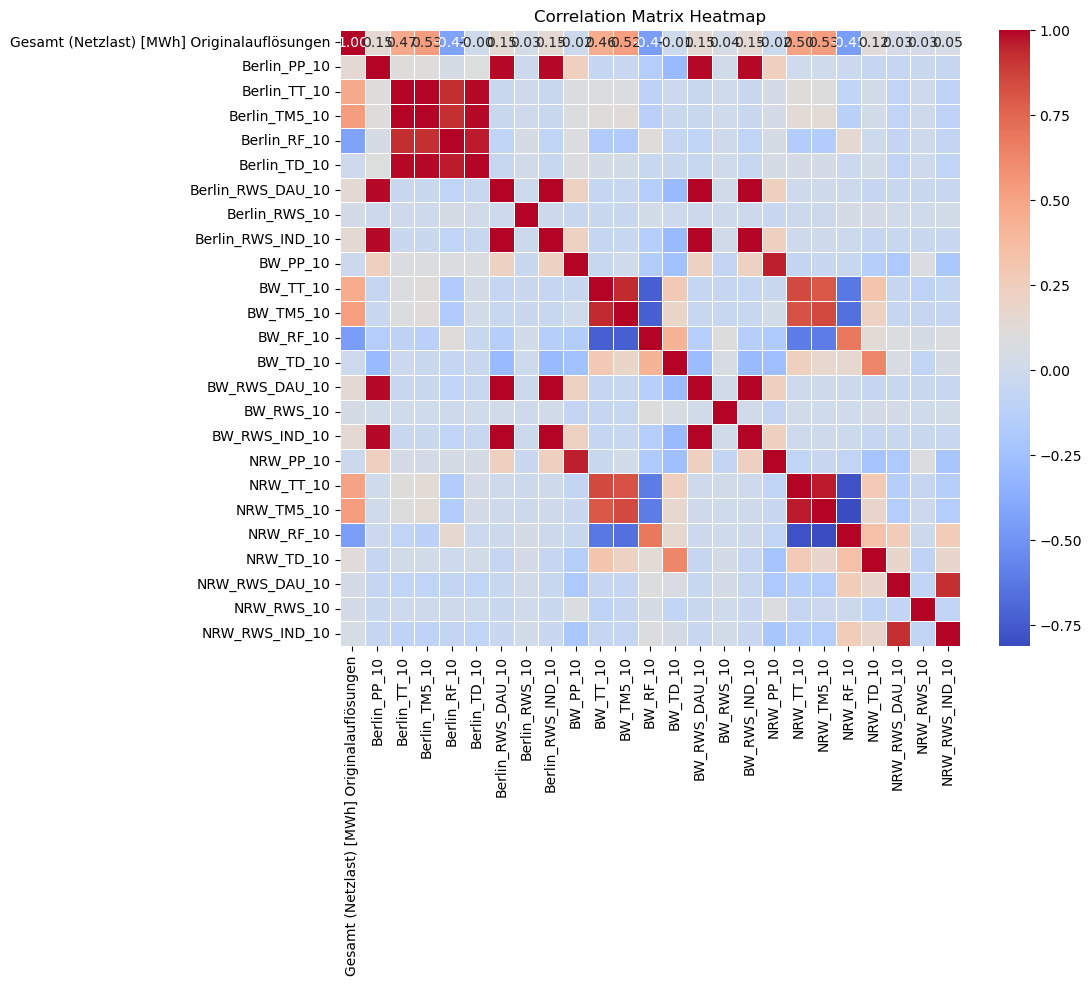

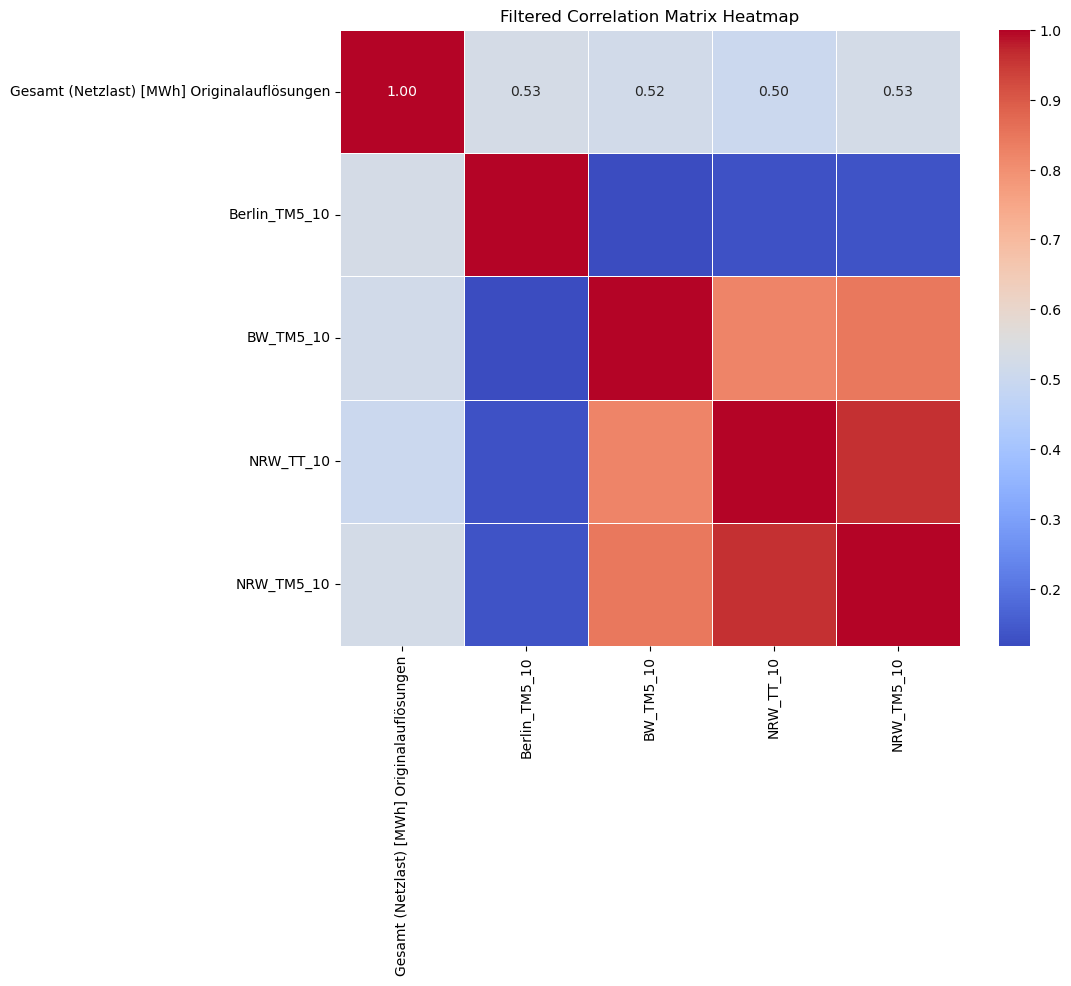

done


In [185]:
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
cut_off_limit = 0.5
#print(endresult_df)
#endresult_df.set_index("DateTime")
corr_df_input = endresult_df.copy()
df_filtered = correlation_matrix(corr_df_input, categorical_columns, cut_off_limit)
print("done")

## 2.2 Reducing dimensionality

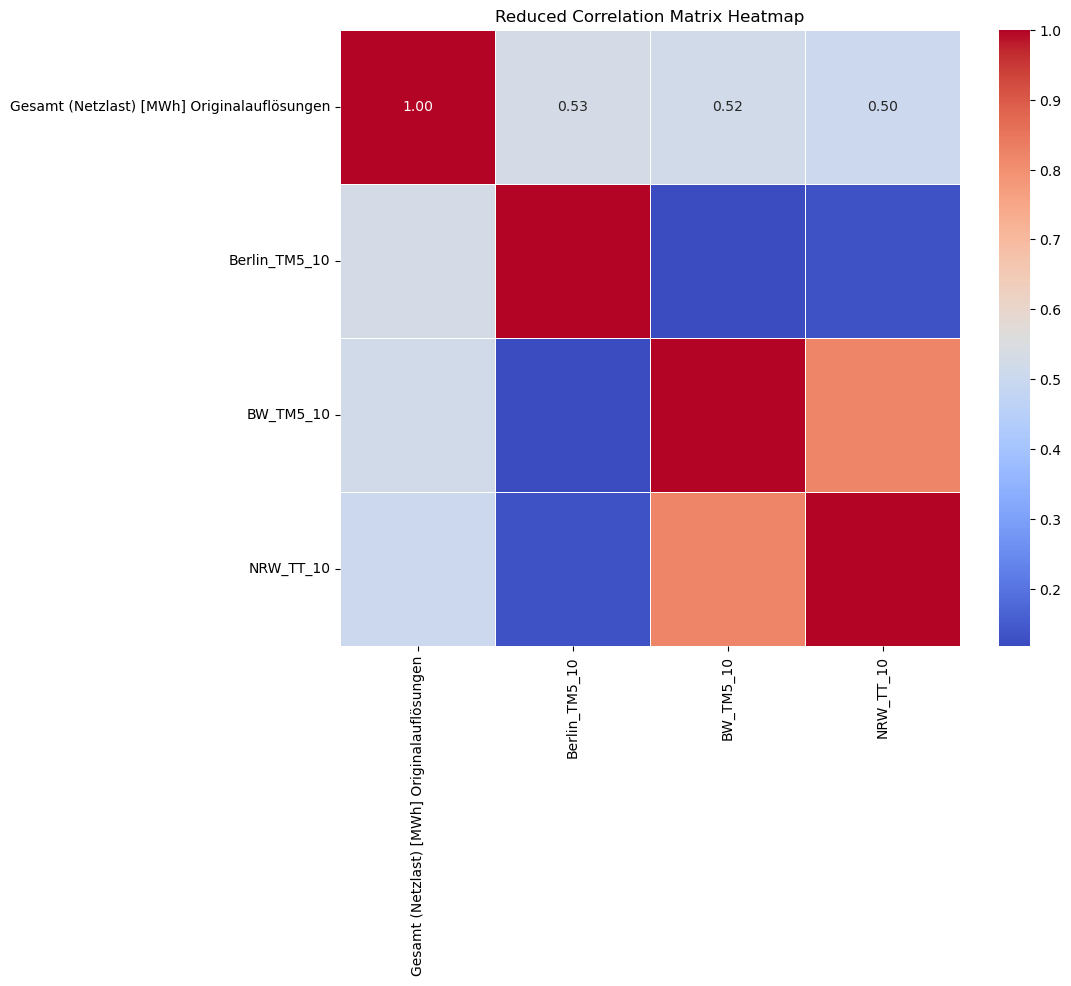

       Gesamt (Netzlast) [MWh] Originalauflösungen            DateTime  \
0                                         11930.50 2016-06-10 00:00:00   
1                                         11764.50 2016-06-10 00:15:00   
2                                         11602.50 2016-06-10 00:30:00   
3                                         11495.00 2016-06-10 00:45:00   
4                                         11384.25 2016-06-10 01:00:00   
...                                            ...                 ...   
12091                                          NaN 2024-06-17 22:45:00   
12092                                          NaN 2024-06-17 23:00:00   
12093                                          NaN 2024-06-17 23:15:00   
12094                                          NaN 2024-06-17 23:30:00   
12095                                          NaN 2024-06-17 23:45:00   

            Land1       Land2         Runde Liga Land3 Land4  Berlin_TM5_10  \
0             NaN         NaN   

In [186]:
# Set the correlation threshold
correlation_threshold = 0.9 # Adjust this threshold as needed
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
#print(df_filtered)
reduce_input_df = df_filtered.copy()
df_reduced = reducing_dimensionality(df_filtered, correlation_threshold,categorical_columns)

print("done")

## 2.3 Normalizing Data 

In [187]:
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]

columns_to_normalize = [col for col in df_reduced.columns if not any(excl in col for excl in categorical_columns)]
scaler = MinMaxScaler()
# Scale the entire dataframe
df_normalized = df_reduced.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])



print("done")


done



## 2.4 Extracting Features out of DateTime

In [188]:
df_time_feature = df_normalized.copy()


df_time_feature['year'] = df_time_feature['DateTime'].dt.year
df_time_feature['month'] = df_time_feature['DateTime'].dt.month
df_time_feature['day'] = df_time_feature['DateTime'].dt.day
df_time_feature['hour'] = df_time_feature['DateTime'].dt.hour
df_time_feature['minute'] = df_time_feature['DateTime'].dt.minute
df_time_feature['day_of_week'] = df_time_feature['DateTime'].dt.dayofweek
df_time_feature['week_of_year'] = df_time_feature['DateTime'].dt.isocalendar().week
df_time_feature['is_weekend'] = df_time_feature['DateTime'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

df_2024_datetime = df_time_feature[df_time_feature['year'] == 2024]
df_2024_datetime = df_2024_datetime["DateTime"]

df_time_feature.drop(columns = ["DateTime"], inplace = True)



print(df_2024_datetime)

# Drop original datetime if you won't need it
print("done")

9600    2024-06-18 00:00:00
9601    2024-06-18 00:15:00
9602    2024-06-18 00:30:00
9603    2024-06-18 00:45:00
9604    2024-06-18 01:00:00
                ...        
12091   2024-06-17 22:45:00
12092   2024-06-17 23:00:00
12093   2024-06-17 23:15:00
12094   2024-06-17 23:30:00
12095   2024-06-17 23:45:00
Name: DateTime, Length: 2496, dtype: datetime64[ns]
done


## 2.5 Encoding categorical values

### 2.5.1 One-Hot Encoding

In [189]:
hot_encoded_df = df_time_feature.copy()
categorical_columns = ["Runde", "Liga"]
hot_encoded_df = pd.get_dummies(hot_encoded_df, columns = categorical_columns)
print("done")

done


### 2.5.2 Ordinal Encoding

In [190]:
#print(football_dic)

temp_path =r"Spielplan"
file_name = "*.csv"
date_column = "DateTime"
date_format = '%d. %b %y %H:%M'
other_date_format = '%d.%m.%Y %H:%M'

football_dic_copy = importing_football_data(temp_path, file_name, date_column, date_format, other_date_format)

country_to_rank = ranking_countries_by_viewership(football_dic_copy)

encoding_columns = ["Land1", "Land2", "Land3", "Land4"]

ordinal_encoded_df = hot_encoded_df.copy()
for column in encoding_columns:
    ordinal_encoded_df[f'{column}_rank'] = ordinal_encoded_df[column].map(country_to_rank)
    
print(ordinal_encoded_df.columns)

df_encoded = ordinal_encoded_df.drop(columns= encoding_columns)
print(len(df_encoded.columns))

df_2024 = df_encoded[df_encoded['year'] == 2024]
deviation_factor = 0.05  # 5% deviation

# Apply Gaussian noise to each value
# The noise will have mean 0 and standard deviation = deviation_factor * actual value
#df_predictions = df_2024.apply(lambda x: x + np.random.normal(0, deviation_factor * x))
# Optionally, create another DataFrame that contains the rows where 'year' is not 2024
df_not_2024 = df_encoded[df_encoded['year'] != 2024]

#print(df_2024)
print(df_not_2024.columns)

Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Land1', 'Land2',
       'Land3', 'Land4', 'Berlin_TM5_10', 'BW_TM5_10', 'NRW_TT_10', 'year',
       'month', 'day', 'hour', 'minute', 'day_of_week', 'week_of_year',
       'is_weekend', 'Runde_Achtelfinale', 'Runde_Finale',
       'Runde_Gruppenphase', 'Runde_Halbfinale', 'Runde_Spiel um Platz 3',
       'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank',
       'Land3_rank', 'Land4_rank'],
      dtype='object')
24
Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'day', 'hour', 'minute',
       'day_of_week', 'week_of_year', 'is_weekend', 'Runde_Achtelfinale',
       'Runde_Finale', 'Runde_Gruppenphase', 'Runde_Halbfinale',
       'Runde_Spiel um Platz 3', 'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM',
       'Land1_rank', 'Land2_rank', 'Land3_rank', 'Land4_rank'],
      dtype='object')


### 2.5.3 Cyclic Encoding

In [191]:

categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
columns_to_normalize = ["year", 'week_of_year', 'month' ]

df_normalized_cyclic = cyclic_encoding(df_not_2024, categorical_columns, columns_to_normalize)
df_normalized_cyclic.fillna(0, inplace=True)

print(df_normalized_cyclic.columns)

Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year', 'is_weekend',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')


In [192]:
# Definieren der kategorischen Spalten und der Spalten, die normalisiert werden sollen
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
columns_to_normalize = ["year", 'week_of_year', 'month' ]

# Anwenden der zyklischen Kodierung und Normalisierung auf den DataFrame df_2024
df_normalized_cyclic_new = cyclic_encoding(df_2024, categorical_columns, columns_to_normalize)

# Ersetzen von fehlenden Werten im DataFrame df_normalized_cyclic durch 0
df_normalized_cyclic_new.fillna(0, inplace=True)

# Ausgabe der Spaltennamen des neuen DataFrames nach der Kodierung und Normalisierung
print(df_normalized_cyclic_new.columns)

Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year', 'is_weekend',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')


# 3. Modelling

In [193]:
%run Modelling.ipynb

## 3.1 Linear Regression

Dieser Code führt eine Zeitreihenaufteilung durch, trainiert ein lineares Regressionsmodell und bewertet es mit den Metriken Mean Squared Error (MSE) und R^2 Score. Anschließend werden die Ergebnisse visualisiert.

Train index: 1503, Test index: 3007
Mean Squared Error: 1.033626862509003
R^2 Score: -15.426219024386473
Train index: 3007, Test index: 4511
Mean Squared Error: 0.029904081756076378
R^2 Score: 0.5306023804392157
Train index: 4511, Test index: 6015
Mean Squared Error: 0.020988147574668103
R^2 Score: 0.6626058143821284
Train index: 6015, Test index: 7519
Mean Squared Error: 0.015071557042611296
R^2 Score: 0.7006341859676574
Train index: 7519, Test index: 9023
Mean Squared Error: 0.01470514148477729
R^2 Score: 0.7363334366497885
Average Mean Squared Error: 0.22285915807342715
Average R^2 Score: -2.559208641389536


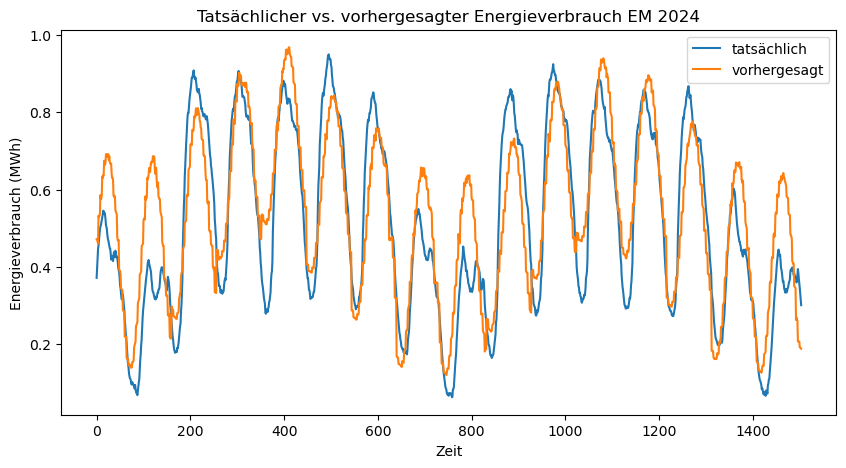

In [35]:
# Importieren der numpy-, pandas- und matplotlib-Bibliothek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importieren von TimeSeriesSplit für Zeitreihenaufteilung
from sklearn.model_selection import TimeSeriesSplit

# Importieren des linearen Regressionsmodells
from sklearn.linear_model import LinearRegression

# Importieren von Metriken zur Modellbewertung
from sklearn.metrics import mean_squared_error, r2_score

# Auswählen der unabhängigen Variablen (Features) aus dem DataFrame
X = df_normalized_cyclic[['Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos']]

# Abhängige Variable (Zielvariable)
y = df_normalized_cyclic['Gesamt (Netzlast) [MWh] Originalauflösungen']
# Auffüllen fehlender Werte mit 0
X = X.fillna(0)  

# Listen zur Speicherung der Mean Squared Error und R^2 Werte Werte
mse_scores = []
r2_scores = []

# Zeitreihenaufteilung mit TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()

# Iteration über die Aufteilungen
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Modell trainieren
    model.fit(X_train, y_train)
    
    # Vorhersage
    y_pred = model.predict(X_test)
    
    # Bewertung
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    # Ausgabe der Indizes und Metriken
    print(f"Train index: {train_index[-1]}, Test index: {test_index[-1]}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    
# Ausgabe der durchschnittlichen Metriken über alle Splits
print(f"Average Mean Squared Error: {np.mean(mse_scores)}")
print(f"Average R^2 Score: {np.mean(r2_scores)}")

# Visualisierung der letzten Vorhersage
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="tatsächlich") # Plotten der tatsächlichen Werte
plt.plot(y_pred, label="vorhergesagt") # Plotten der vorhergesagten Werte
plt.legend() # Hinzufügen der Legende
plt.title("Actual vs Predicted Energy Consumption")  # Titel der Grafik
plt.xlabel("Zeit")
plt.ylabel("Energieverbrauch (MWh)")
plt.title("Tatsächlicher vs. vorhergesagter Energieverbrauch EM 2024")
plt.show() # Anzeigen der Grafik



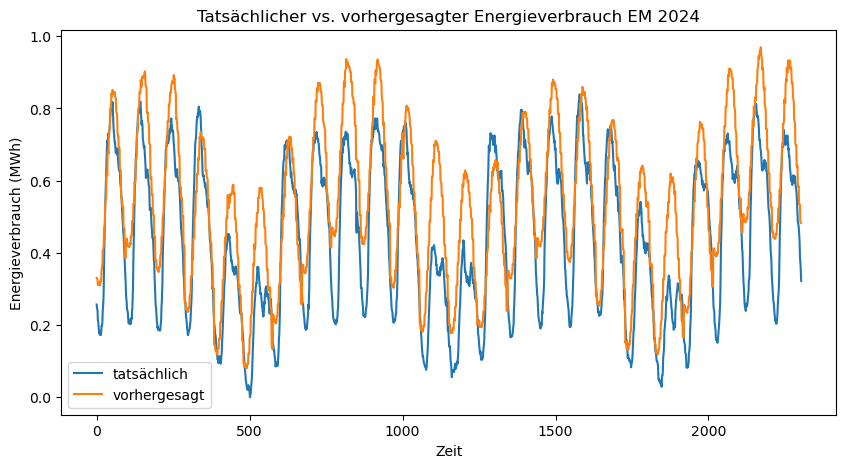

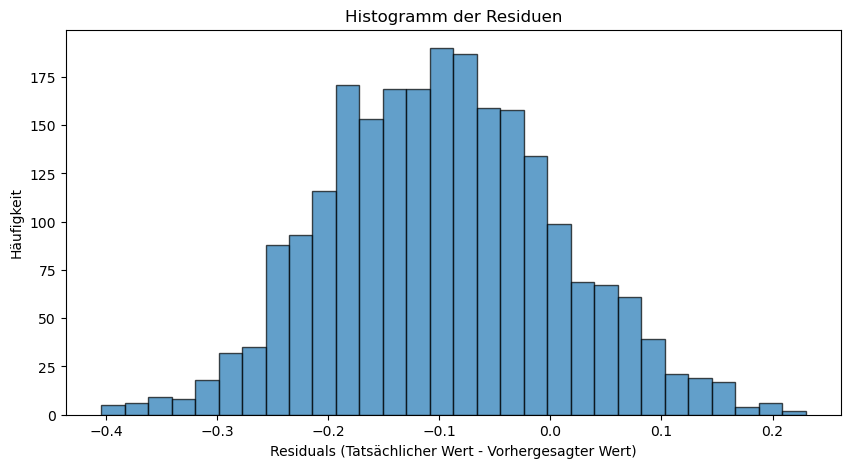

In [36]:
#Vorhersage Em 2024
new_data_prepared = df_normalized_cyclic_new[['Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos']]

# Fülle fehlende Werte in den neuen Daten auf
new_data_prepared = new_data_prepared.fillna(0)

# Verwende das bereits trainierte Modell für Vorhersagen
y_new_pred = model.predict(new_data_prepared)



# Zeige die Vorhersagen an
plt.figure(figsize=(10, 5))
#Gegenüberstellung der u simulierten Daten mit dem tatsächlichen Verbrauch während der EM 2024
y_2024 = df_normalized_cyclic_new['Gesamt (Netzlast) [MWh] Originalauflösungen']
plt.plot(y_2024.values, label="tatsächlich")

# Visualisierung des simulierten Verbrauchs

plt.plot(y_new_pred, label="vorhergesagt")

plt.legend()
plt.title("Tatsächlicher vs. vorhergesagter Energieverbrauch EM 2024") # Titel der Grafik
plt.xlabel("Zeit")
plt.ylabel("Energieverbrauch (MWh)")
plt.show() # Anzeigen der Grafik


# Berechnung der Residuen
residuals = y_2024.values - y_new_pred

# Plotten des Histogramms der Residuen
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals (Tatsächlicher Wert - Vorhergesagter Wert)')
plt.ylabel('Häufigkeit')
plt.title('Histogramm der Residuen')
plt.show()



## 3.2 Random Forest

Dieser Code führt eine Zeitreihenaufteilung durch, trainiert ein Random Forest Regressor Modell und bewertet es mit den Metriken MSE und R^2 Score. Anschließend werden die Ergebnisse visualisiert.

Train index: 1503, Test index: 3007
Mean Squared Error: 0.001188793992685106
R^2 Score: 0.981107891825373
Train index: 3007, Test index: 4511
Mean Squared Error: 0.002008985528633099
R^2 Score: 0.9684654077471941
Train index: 4511, Test index: 6015
Mean Squared Error: 0.001192414099833116
R^2 Score: 0.9808313914936428
Train index: 6015, Test index: 7519
Mean Squared Error: 0.0027804194159429404
R^2 Score: 0.9447726257179813
Train index: 7519, Test index: 9023
Mean Squared Error: 0.0015328577695849712
R^2 Score: 0.9725155082234653
Average Mean Squared Error: 0.0017406941613358463
Average R^2 Score: 0.9695385650015312


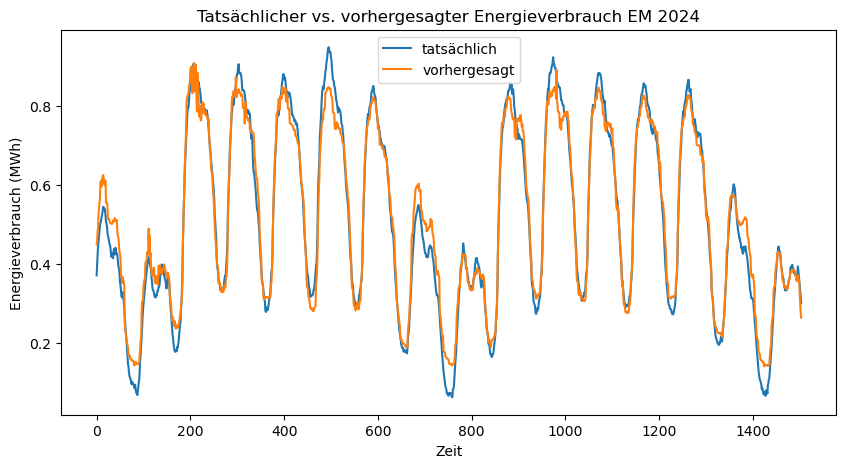

In [107]:
# Importieren der numpy-, pandas- und matplotlib-Bibliothek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importieren von TimeSeriesSplit für die Zeitreihenaufteilung
from sklearn.model_selection import TimeSeriesSplit

# Importieren des Random Forest Regressors
from sklearn.ensemble import RandomForestRegressor

 # Importieren der Metriken zur Modellbewertung
from sklearn.metrics import mean_squared_error, r2_score



# Zielvariable (y) und Features(X) definieren
#X = df_normalized_cyclic[['Berlin_TM5_10',
#       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year',
#       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
#       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
#       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
#       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
#       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos']]

X = df_normalized_cyclic[['Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos']]

y = df_normalized_cyclic['Gesamt (Netzlast) [MWh] Originalauflösungen']

# Fehlende Werte durch Null ersetzen
X = X.fillna(0)

# Listen zur Speicherung der Fehlermaße
mse_scores = []
r2_scores = []

# Zeitreihenaufteilung mit TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5) # Aufteilen der Daten in 5 Teile
model = RandomForestRegressor(n_estimators=100, random_state=42)  # Initialisieren des Random Forest Modells

# Iteration über die Aufteilungen
for train_index, test_index in tscv.split(X):
    # Aufteilen der Features und Zielvariable in Trainings- und Testdaten
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Modell trainieren
    model.fit(X_train, y_train)
    
    # Vorhersage
    y_pred = model.predict(X_test)
    
    # Bewertung
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Speichern der Fehlermaße
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    # Ausgabe der Indizes und Metriken
    print(f"Train index: {train_index[-1]}, Test index: {test_index[-1]}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

# Ausgabe der durchschnittlichen Metriken über alle Splits
print(f"Average Mean Squared Error: {np.mean(mse_scores)}")
print(f"Average R^2 Score: {np.mean(r2_scores)}")

# Visualisierung der letzten Vorhersage
plt.figure(figsize=(10, 5))  # Festlegen der Größe der Grafik
plt.plot(y_test.values, label="tatsächlich")  # Plotten der tatsächlichen Werte
plt.plot(y_pred, label="vorhergesagt")  # Plotten der vorhergesagten Werte
plt.legend() # Hinzufügen der Legende
plt.title("Tatsächlicher vs. vorhergesagter Energieverbrauch EM 2024") # Titel der Grafik
plt.xlabel("Zeit")
plt.ylabel("Energieverbrauch (MWh)")
plt.show() # Anzeigen der Grafik




Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Beste Parameter gefunden:
{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Bestes Ergebnis (negative MSE):
0.00170367579280731
Train index: 1503, Test index: 3007
Train Mean Squared Error: 7.163694446078524e-05
Test Mean Squared Error: 0.00118463499434903
Train R^2 Score: 0.9988281696272396
Test R^2 Score: 0.9811739859063884
Train index: 3007, Test index: 4511
Train Mean Squared Error: 8.80338578375455e-05
Test Mean Squared Error: 0.0020001502245899348
Train R^2 Score: 0.9985809154261563
Test R^2 Score: 0.9686040935199186
Train index: 4511, Test index: 6015
Train Mean Squared Error: 0.00013403320328333763
Test Mean Squared Error: 0.001205058397440061
Train R^2 Score: 0.9978826155804439
Test R^2 Score: 0.980628128557806
Train index: 6015, Test index: 7519
Train Mean Squared Error: 0.00016798416682777456
Test Mean Squared Error: 0.002681390863967341
Train R^2 Score

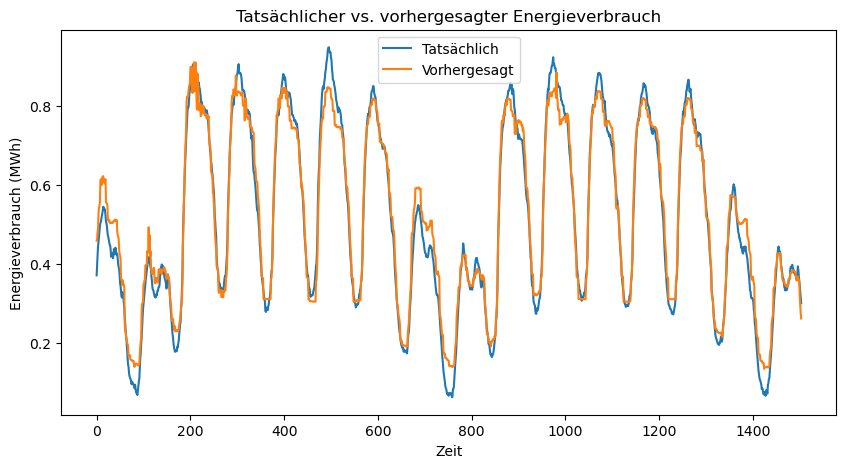

In [24]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dummy DataFrame zur Demonstration (ersetze dies mit deinem tatsächlichen DataFrame)
# df_normalized_cyclic = pd.read_csv('your_data.csv')

# Feature- und Zielvariablen definieren
X = df_normalized_cyclic[['Berlin_TM5_10', 'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank', 'Land4_rank',
       'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos',
       'day_of_week_sin', 'day_of_week_cos']]
y = df_normalized_cyclic['Gesamt (Netzlast) [MWh] Originalauflösungen']

# Fehlende Werte durch Null ersetzen
X = X.fillna(0)

# Parameter-Grid für die Suche
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialisiere den Random Forest Regressor
model = RandomForestRegressor(random_state=42)

# Initialisiere GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Führe Grid Search aus
grid_search.fit(X, y)

# Ausgabe der besten Parameter
print("Beste Parameter gefunden:")
print(grid_search.best_params_)

# Ausgabe des besten Scores
print("Bestes Ergebnis (negative MSE):")
print(-grid_search.best_score_)

# Das beste Modell verwenden
best_model = grid_search.best_estimator_

# Evaluierung des besten Modells
mse_scores = []
r2_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_model.fit(X_train, y_train)
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    mse_scores.append(test_mse)
    r2_scores.append(test_r2)

    print(f"Train index: {train_index[-1]}, Test index: {test_index[-1]}")
    print(f"Train Mean Squared Error: {train_mse}")
    print(f"Test Mean Squared Error: {test_mse}")
    print(f"Train R^2 Score: {train_r2}")
    print(f"Test R^2 Score: {test_r2}")

print(f"Average Test Mean Squared Error: {np.mean(mse_scores)}")
print(f"Average Test R^2 Score: {np.mean(r2_scores)}")

# Visualisierung der letzten Vorhersage
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Tatsächlich")
plt.plot(y_pred_test, label="Vorhergesagt")
plt.legend()
plt.title("Tatsächlicher vs. vorhergesagter Energieverbrauch")
plt.xlabel("Zeit")
plt.ylabel("Energieverbrauch (MWh)")
plt.show()

- Der Code trainiert ein Random Forest Regressionsmodell auf einer Zeitreihen-Dataset.
- Die Daten werden in 5 Splits aufgeteilt, wobei jeweils ein Teil als Testdaten und der Rest als Trainingsdaten genutzt wird.
- Das Modell wird für jeden Split trainiert und bewertet (mittels MSE und R²).
    - R²und MSE besser ohne die Features Runde_Gruppenphase/.../Runde_Finale
- Durchschnittliche Fehlermaße werden berechnet und die Vorhersagen des letzten Splits visualisiert.

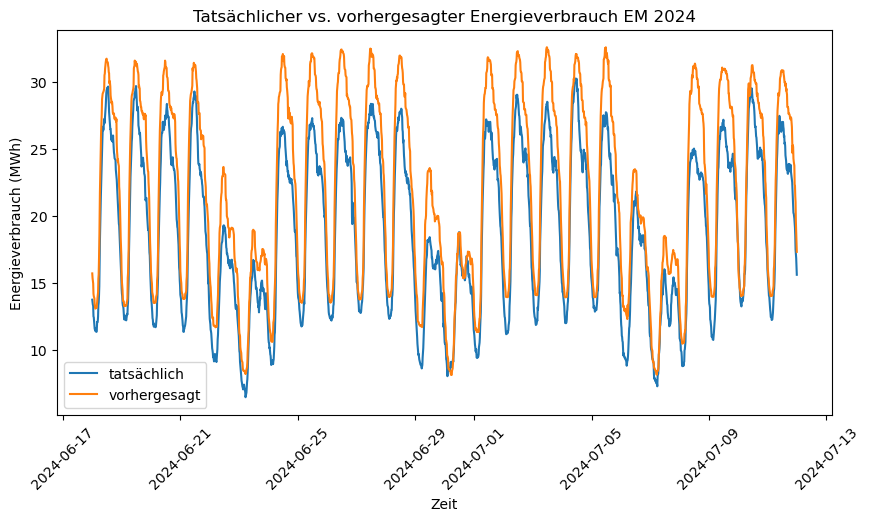

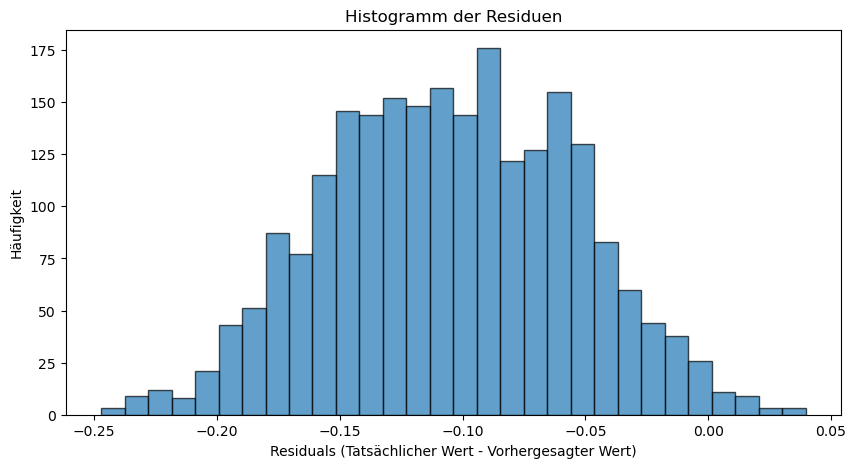

In [117]:
#Vorhersage des Energieverbrauchs während der EM 2024

#die neuen Daten zur EM 2024 definieren
#new_data = df_normalized_cyclic_new[['Berlin_TM5_10',
       #'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year',
       #'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       #'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       #'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       #'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       #'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos']]
        
new_data = df_normalized_cyclic_new[['Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos']]

# Fehlende Werte durch Null ersetzen
new_data = new_data.fillna(0)

# Vorhersage des Verbrauchs während der EM 2024
y_pred_new = model.predict(new_data)

#Gegenüberstellung der u simulierten Daten mit dem tatsächlichen Verbrauch während der EM 2024

plt.figure(figsize=(10, 5))

y_2024 = df_normalized_cyclic_new['Gesamt (Netzlast) [MWh] Originalauflösungen']
y_2024_new_reshaped = y_2024.values.reshape(-1, 1)

# Create a new MinMaxScaler instance for the target feature
scaler_target = MinMaxScaler()

# Set the min_ and scale_ using the last column of the original scaler
# These values need to be arrays, so we wrap them in np.array() and reshape
scaler_target.min_ = np.array([scaler.min_[-1]])
scaler_target.scale_ = np.array([scaler.scale_[-1]])

# Perform the inverse transformation on the reshaped target variable
y_2024_original = scaler_target.inverse_transform(y_2024_new_reshaped)
plt.plot(df_2024_datetime, y_2024_original, label="tatsächlich")

# Visualisierung des simulierten Verbrauchs
# Reshape y_pred_new into a 2D array
y_pred_new_reshaped = y_pred_new.reshape(-1, 1)

scaler_target = MinMaxScaler()
scaler_target.min_ = scaler.min_[-1]    # Extract min for target feature
scaler_target.scale_ = scaler.scale_[-1]  # Extract scale for target feature

# Perform the inverse transformation on the predicted target variable
y_pred_original = scaler_target.inverse_transform(y_pred_new_reshaped)
# Reshape the result back into a 1D array if needed
#original_data = original_data.flatten()
plt.plot(df_2024_datetime, y_pred_original, label="vorhergesagt")

plt.legend()
plt.title("Tatsächlicher vs. vorhergesagter Energieverbrauch EM 2024") # Titel der Grafik
plt.xticks(rotation=45)
plt.xlabel("Zeit")
plt.ylabel("Energieverbrauch (MWh)")
plt.show() # Anzeigen der Grafik


# Berechnung der Residuen
residuals = y_2024.values - y_pred_new

# Plotten des Histogramms der Residuen
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals (Tatsächlicher Wert - Vorhergesagter Wert)')
plt.ylabel('Häufigkeit')
plt.title('Histogramm der Residuen')
plt.show()



Hier wurden die Vorhersagen des trainierten Modells für neue Daten erstellt und visualisiert. Indem der Spielplan und die Wetterdaten gegeben und der Verbrauch mit dem trainierten Modell vorhergesagt wird.



## 3.3 LSTM

### 3.3.1 Datentypen für LSTM anpassen

In [195]:

bool_columns = ['Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
                'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
                'Liga_EM', 'Liga_WM']

df_normalized_cyclic[bool_columns] = df_normalized_cyclic[bool_columns].astype(int)

float_columns = ['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10', 'BW_TM5_10',
                  'NRW_TT_10', 'Land1_rank', 'Land2_rank', 'Land3_rank', 'Land4_rank']

df_normalized_cyclic[float_columns] = df_normalized_cyclic[float_columns].astype(np.float32)

int_columns = ['year','hour_sin','hour_cos', 'minute_sin', 'minute_cos', 'day_of_week_sin',
               'day_of_week_cos',"is_weekend", 'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase', 'Runde_Halbfinale',
               'Runde_Spiel um Platz 3', 'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM']

df_normalized_cyclic[int_columns] = df_normalized_cyclic[int_columns].astype(np.int32)

### 3.3.2 Dataframe in Sequenzen und Tensor umwandeln

In [196]:

target_column = 'Gesamt (Netzlast) [MWh] Originalauflösungen'

# Separate features and target
X = df_normalized_cyclic.drop(columns=[target_column])
y = df_normalized_cyclic[target_column]

sequence_length = 96

# Create sequences
X_sequences, y_sequences = create_sequences(X.values, y.values, sequence_length)

# Reshape X for LSTM: [samples, time steps, features]
num_features = X_sequences.shape[2]  # Number of features
X_sequences = X_sequences.reshape((X_sequences.shape[0], X_sequences.shape[1], num_features))

print(f'X_sequences shape: {X_sequences.shape}')
print(f'y_sequences shape: {y_sequences.shape}')


X_sequences shape: (9504, 96, 27)
y_sequences shape: (9504,)


### 3.3.3 Festlegung der Modellarchitektur

In [203]:
layers = 32
epochs = 20
regularization = 0.00001
dropout = 0.3
learning_rate = 0.0005
early_stopping = 8

### 3.3.4 Train und Test Split mit Validierung

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
split_results = []

train_losses_per_split = []
val_losses_per_split = []

for train_index, test_index in tscv.split(X_sequences):

    X_train, X_test = X_sequences[train_index], X_sequences[test_index]
    y_train, y_test = y_sequences[train_index], y_sequences[test_index]


    history,model = lstm_model(X_train, X_test,y_train, y_test, layers, epochs, regularization, dropout, learning_rate, early_stopping)
    
    # Evaluate the model
    # Collect loss for plotting
    train_losses_per_split.append(history.history['loss'])
    val_losses_per_split.append(history.history['val_loss'])
    
    loss = model.evaluate(X_test, y_test)
    split_results.append(loss)

# Average performance over all splits
average_loss = np.mean(split_results)
print(f'Average validation loss over all splits: {average_loss}')

# Plot training and validation losses across splits
for i in range(len(train_losses_per_split)):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_per_split[i], label=f'Training Loss (Split {i+1})')
    plt.plot(val_losses_per_split[i], label=f'Validation Loss (Split {i+1})')
    plt.title(f'Training vs Validation Loss for Split {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 0.1450 - val_loss: 0.0847
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0276 - val_loss: 0.0730
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.0205 - val_loss: 0.0726
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - loss: 0.0153 - val_loss: 0.0732
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0133 - val_loss: 0.0550
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0108 - val_loss: 0.0616
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.0094 - val_loss: 0.0588
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0098 - val_loss: 0.0591
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 0.0086 - val_loss: 0.0538
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.0076 - val_loss: 0.0618
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.0071 - val_loss: 0.0565
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss:

### 3.3.5 Finales Model

In [ ]:

# Assuming the model performed well, we now train on the entire dataset (except the final test set)
train_size = int(len(X_sequences) * 0.9)
X_train_final, X_test_final = X_sequences[:train_size], X_sequences[train_size:]
y_train_final, y_test_final = y_sequences[:train_size], y_sequences[train_size:]


lstm_final, model_final = lstm_model(X_train_final, X_test_final,y_train_final, y_test_final, layers, epochs, regularization, dropout, learning_rate, early_stopping)


# Final evaluation
final_loss = model_final.evaluate(X_test_final, y_test_final)
print(f'Final test loss: {final_loss}')

y_pred = model_final.predict(X_test_final)
r2 = r2_score(y_test_final, y_pred)

print(f'R² Score: {r2}')

# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_final, label='Actual Values', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicted Values', color='red', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted Values')
plt.legen()
plt.xlabel('Time')
plt.ylabel('Value')


C:\Users\Isabell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


### 3.3.6 Vorhersage der EM 2024 

In [157]:

bool_columns = ['Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
                'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
                'Liga_EM', 'Liga_WM']

df_normalized_cyclic_new[bool_columns] = df_normalized_cyclic_new[bool_columns].astype(int)

float_columns = ['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10', 'BW_TM5_10',
                  'NRW_TT_10', 'Land1_rank', 'Land2_rank', 'Land3_rank', 'Land4_rank']

df_normalized_cyclic_new[float_columns] = df_normalized_cyclic_new[float_columns].astype(np.float32)

int_columns = ['year','hour_sin','hour_cos', 'minute_sin', 'minute_cos', 'day_of_week_sin',
               'day_of_week_cos',"is_weekend", 'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase', 'Runde_Halbfinale',
               'Runde_Spiel um Platz 3', 'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM']

df_normalized_cyclic_new[int_columns] = df_normalized_cyclic_new[int_columns].astype(np.int32)

In [158]:
target_column = 'Gesamt (Netzlast) [MWh] Originalauflösungen'

# Separate features and target
#print(df_normalized_cyclic_new)
X = df_normalized_cyclic_new.drop(columns=[target_column])
y = df_normalized_cyclic_new[target_column]

sequence_length = 96

# Create sequences
X_sequences_em, y_sequences_em = create_sequences(X.values, y.values, sequence_length)
#print(X_sequences)

num_features = X_sequences_em.shape[2]  # Number of features
X_sequences_em = X_sequences_em.reshape((X_sequences_em.shape[0], X_sequences_em.shape[1], num_features))

print(f'X_sequences shape: {X_sequences_em.shape}')
#print(f'y_sequences shape: {y_sequences.shape}')

y_pred_2024 = model_final.predict(X_sequences_em)

print("done")

X_sequences shape: (3552, 96, 27)
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
done


13056   2024-06-18 00:00:00
13057   2024-06-18 00:15:00
13058   2024-06-18 00:30:00
13059   2024-06-18 00:45:00
13060   2024-06-18 01:00:00
                ...        
16699   2024-06-17 22:45:00
16700   2024-06-17 23:00:00
16701   2024-06-17 23:15:00
16702   2024-06-17 23:30:00
16703   2024-06-17 23:45:00
Name: DateTime, Length: 3648, dtype: datetime64[ns]
[0.28615415 0.2724007  0.26621678 ... 0.         0.         0.        ]


Text(0, 0.5, 'Value')

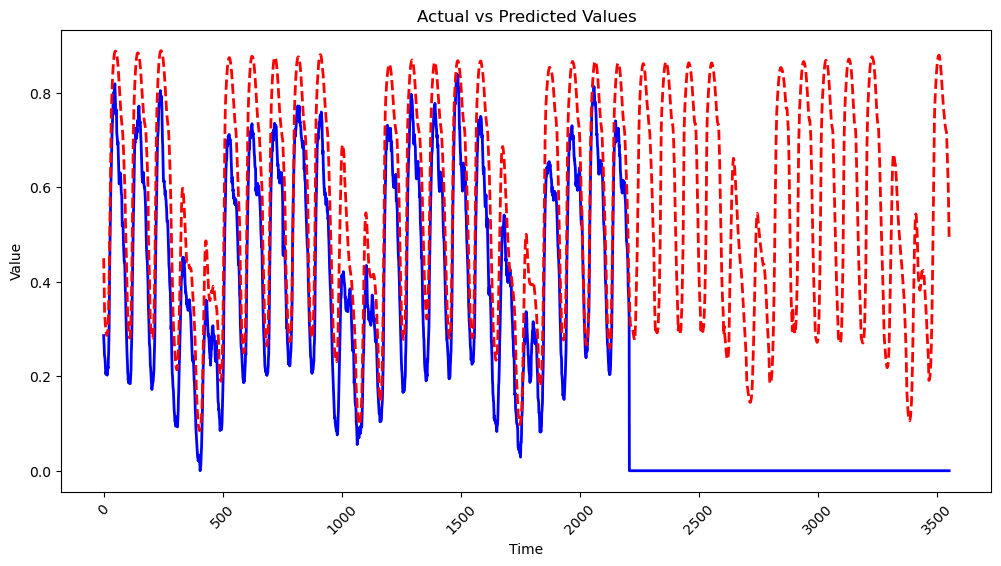

In [159]:
plt.figure(figsize=(12, 6))
print(df_2024_datetime)
print(y_sequences)
plt.plot(y_sequences_em, label='Actual Values', color='blue', linewidth=2)
plt.plot(y_pred_2024, label='Predicted Values', color='red', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted Values')

plt.xticks(rotation=45) 
plt.xlabel('Time')
plt.ylabel('Value')
